In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import itertools
import time
from tqdm import tqdm
import sympy as sp
x = sp.var('x')
from sympy import Symbol
from sympy.solvers import solve
import math
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Import our adaptive module:
from adaptive_MDP import Adaptive
from non_adaptive import NonAdaptive

In [4]:
# Initial parameters
mu = 0.00015
gamma = 0.0027
beta = 0.00096
phi = 0.0044

kappa = 0.8  #C^I/C^S
theta = 1.7 #C^Z/C^S

# R values:
Rmu = mu/(mu+ gamma)
Rphi = phi/(mu + gamma)

### Adaptive parameters
b_s = 24
b_i = 24
b_z = 24
a_i = 0
a_z = 0
a_s = 0 
nu = 0.1375
tau = 3
delta = 0.9986

### Simulation parameters
t_max = 10000
steps = 100
x00 = [9999, 1, 0]
# Note: our start point is not [1,0,0]
# Because the disease-free equilibrium is stable for models with demographics.

Ci = 3
Cs = Ci/kappa
Cz = Cs*theta

R0 = Ci*beta/(gamma+mu)
roots = solve_polynomial(Rphi, Rmu, R0, kappa, theta)

# Initialize adaptive instances
instance_adaptive = Adaptive(mu, gamma, beta, phi,
                             b_s, b_i, b_z, 
                             a_s, a_i, a_z,
                             nu, tau, delta,
                             t_max, steps, x00, ci_use=Ci, cz_use=Cz)
start = time.time()
instance_adaptive.patch_uni_solutions()
end = time.time()
print(f"Running the adaptive algorithm took {end - start} seconds.")

start = time.time()

# To compare, we take the Cs obtained at the end of this algorithm (Ex post)
Cs_start = instance_adaptive.Cs[0] # Adaptive Cs from the beginning of the disease.
Cs_final = instance_adaptive.Cs[len(instance_adaptive.Cs)-1] # Adaptive Cs from the end of the disease

instance_non_adaptive_ex_ante = NonAdaptive(
    mu, gamma, beta, phi, Cs_start, Cs_start*kappa, Cs_start*theta, x00, t_max)

instance_non_adaptive_ex_post = NonAdaptive(
    mu, gamma, beta, phi, Cs_final, Cs_final*kappa, Cs_final*theta, x00, t_max)

instance_non_adaptive_ex_ante.solve_odes_system()
instance_non_adaptive_ex_post.solve_odes_system()

end = time.time()
print(f"Running the NON adaptive algorithms took {end - start} seconds.")

Running the adaptive algorithm took 172.57427191734314 seconds.


100%|█████████████████████████████████████████████████████████████████████| 1000001/1000001 [00:42<00:00, 23630.50it/s]


Running the NON adaptive algorithms took 90.42918109893799 seconds.


In [5]:
R0_start = (Cs_start*kappa)*beta/(gamma+mu)
R0_final = (Cs_final*kappa)*beta/(gamma+mu)

roots_start = solve_polynomial(Rphi, Rmu, R0_start, kappa, theta)
roots_final = solve_polynomial(Rphi, Rmu, R0_final, kappa, theta)

print(f"""

Using Cs_start non-adaptive:

R0 = {R0_start}
theoretical roots = {roots_start}
convergence point = {instance_non_adaptive_ex_ante.I[-1:]/sum(x00)}

Using Cs_final non-adaptive:

R0 = {R0_final}
theoretical roots = {roots_final}
convergence point = {instance_non_adaptive_ex_post.I[-1:]/sum(x00)}
""")



Using Cs_start non-adaptive:

R0 = 3.233684210526316
theoretical roots = [0.3834936922012127]
convergence point = [0.3834937]

Using Cs_final non-adaptive:

R0 = 3.2010207336523124
theoretical roots = [0.38297354009116397]
convergence point = [0.38297354]



Plot the adaptive solution:

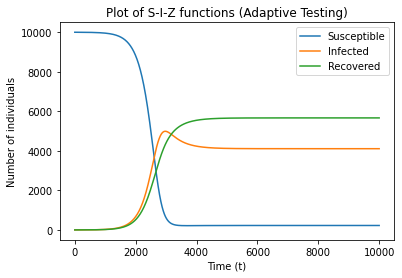

In [6]:
t = np.linspace(0, instance_adaptive.t_max, len(instance_adaptive.S))
instance_adaptive.plot_ode_solution(t = t, title = 'Adaptive Testing')

In [7]:
print(f"Final point attached at Adaptive: {instance_adaptive.I[-1:]}")
print(f"Final point attached at Non Adaptive ex ante: {instance_non_adaptive_ex_ante.I[-1:]}")
print(f"Final point attached at Non Adaptive ex post: {instance_non_adaptive_ex_post.I[-1:]}")

Final point attached at Adaptive: [4108.84051829]
Final point attached at Non Adaptive ex ante: [3834.93695794]
Final point attached at Non Adaptive ex post: [3829.73543876]


In [5]:
cs_unistep = []
for i in range(len(instance_adaptive.Cs)):
    cs_unistep = cs_unistep + [instance_adaptive.Cs[i]]*steps

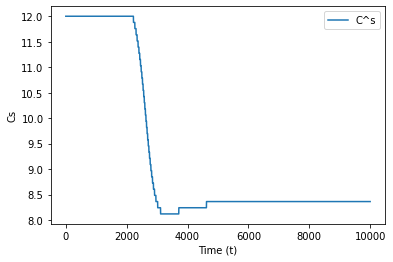

In [6]:
plt.plot(np.linspace(0,t_max,len(cs_unistep)), cs_unistep, label="C^s")
plt.xlabel("Time (t)")
plt.ylabel("Cs")
plt.legend(loc = "upper right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

### Comparison
Between *ex_ante, ex_post* non adaptive models and the adaptive setting.

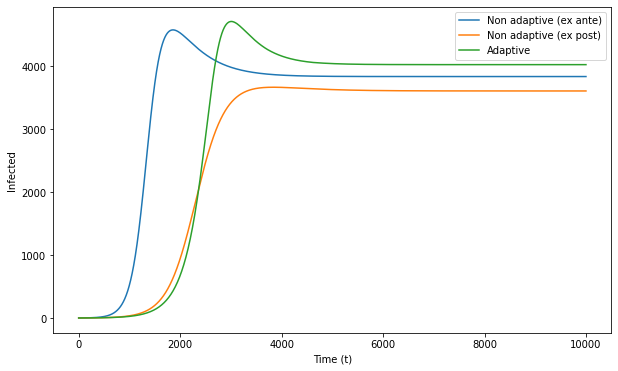

In [8]:
plt.plot(
    np.linspace(0,t_max,len(instance_non_adaptive_ex_ante.I)),
    instance_non_adaptive_ex_ante.I, label="Non adaptive (ex ante)")
plt.plot(
    np.linspace(0,t_max,len(instance_non_adaptive_ex_post.I)),
    instance_non_adaptive_ex_post.I, label="Non adaptive (ex post)")
plt.plot(
    np.linspace(0,t_max,len(instance_adaptive.I)),
    instance_adaptive.I, label="Adaptive")

# plt.axvline(x = 2400, color = 'b')
    
plt.xlabel("Time (t)")
plt.ylabel("Infected")
plt.legend(loc = "upper right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

In [19]:
print(Cs_start)
print(Cs_final)

12.0
8.363636363636363


Comments:

- 

In [9]:
instance_adaptive.val_func_vals[0]

[[5.933185726078457, 3.9582272628396318, 1.9804999814068005, 0],
 [5.933185729239774, 3.9582272628396318, 1.9804999814068005, 0],
 [5.933189245041065, 3.9582284369229788, 1.9804999814068005, 0]]

In [3]:
def get_coefficients_cubic(Rphi, Rmu, R0, kappa, theta):

    ### Returns the coefficients x3,x2,x1,x0 of the cubic polynomial in the notes.

    """
    kappa := C^i/C^s
    theta := C^z/C^s
    """

    x_3 = (Rphi**2)*(R0) + Rmu*(Rphi**2)*(kappa -1)
    
    x_2 = Rphi*(R0*(1 - Rphi) + Rmu*(R0 + Rphi))
    x_2 = x_2 + Rphi*(Rmu*(1 - Rmu)*(theta - 1) + Rmu*(1 + Rmu)*(kappa - 1)) 

    x_1 = Rmu*(R0*(1 - Rphi)  + Rphi*(1 - R0)  + Rmu*Rphi)
    x_1 = x_1+ Rmu*((1 - Rmu)*(theta - 1) + Rmu*(kappa - 1))

    x_0 = (Rmu**2)*(1 - R0)

    return [x_0,x_1,x_2,x_3]

def nmbr_rts_interval(Rphi, Rmu, val_tuple):

    kappa = val_tuple[0]
    theta = val_tuple[1]
    
    print(f"Processing tuple {(kappa,theta)}.")
    start_tuple = time.time()

    R0s = list(np.linspace(0.0001,2,1000))
    vals = []

    for R0 in tqdm(R0s):

        # Compute number of roots using Sturm's Theorem

        coefficients = get_coefficients_cubic(Rphi, Rmu, R0, kappa, theta)
        pol = sum([coefficients[i]*x**i for i in range(len(coefficients))])
        sturm_seq = sp.sturm(pol) # sturm sequence

        values_at_start = [float(sp.Poly(pol_sturm,x).eval(0)) for pol_sturm in sturm_seq]
        values_at_end = [float(sp.Poly(pol_sturm,x).eval(1)) for pol_sturm in sturm_seq]

        count_start = len(list(itertools.groupby(values_at_start, lambda values_at_start: values_at_start > 0)))
        count_end = len(list(itertools.groupby(values_at_end, lambda values_at_end: values_at_end > 0)))

        ans = count_start - count_end
        vals.append(ans)

    answer = max(vals)
    return answer

def evaluate_cubic(i, Rphi, Rmu, R0, kappa, theta):
    [x_0,x_1,x_2,x_3] = get_coefficients_cubic(Rphi, Rmu, R0, kappa, theta)
    return x_3*(i**3) + x_2*(i**2) + x_1*i + x_0

def solve_polynomial(Rphi, Rmu, R0, kappa, theta):
    
    x = Symbol('x')
    resp = solve(evaluate_cubic(x, Rphi, Rmu, R0, kappa, theta), x)
    resp = [(float(expr.as_real_imag()[0]), float(expr.as_real_imag()[1]) ) for expr in resp]
    resp = [expr[0] for expr in resp if expr[0]>0 and abs(expr[1])<1e-15]
    
    return resp

def get_convergence_point(
    N, recovered, prop_infected,
    mu, gamma, beta, phi,
    Cs, Ci, Cz,
    t_max):
    
    initial_infected = math.floor(prop_infected*N)
    x00 = [N - initial_infected - recovered, initial_infected, recovered]
    non_adaptive = NonAdaptive(mu, gamma, beta, phi, Cs, Ci, Cz, x00, t_max, dt=0.1)
    non_adaptive.solve_odes_system(method='odeint')
    equ_attached = non_adaptive.I[len(non_adaptive.I) - 1]/sum(x00)
    return equ_attached